In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import os
import glob
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda")


import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# skip-connection residual block; for some reason the original implementation doesn't have activation at output
class ResidualBlock(nn.Module):
    def __init__(self, n_features,norm_layer=nn.InstanceNorm2d):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_features, n_features, 3),
            norm_layer(n_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_features, n_features, 3),
            norm_layer(n_features)
        )
    def forward(self, x):
        return x + self.block(x)

# Resnet generator with choice of norm layer
class ResnetGenerator(nn.Module):
    def __init__(self,num_residual_blocks=6,default_norm_layer=nn.InstanceNorm2d):
        super(ResnetGenerator, self).__init__()  
        
        def conv_block(in_channels,out_channels,kernel_size,stride,padding,norm_layer=default_norm_layer,padding_mode='reflect'):
            if norm_layer != False:
                return [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,padding_mode=padding_mode),
                        norm_layer(out_channels),
                        nn.ReLU(inplace=True)]
            else:
                return [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,padding_mode=padding_mode),
                        nn.ReLU(inplace=True)]
            
        # Used in upsampling
        def deconv_block(in_channels,out_channels,kernel_size=3,stride=2,padding=1, output_padding=1,norm_layer=default_norm_layer):
            if norm_layer != False:
                return [nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,output_padding),
                        norm_layer(out_channels),
                        nn.ReLU(inplace=True)]
            else:
                return [nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,output_padding),
                        nn.ReLU(inplace=True)]
         
        output_layer = [nn.Conv2d(in_channels=64,out_channels=3,kernel_size=7,padding=3,padding_mode='reflect'),nn.Tanh()]
        
        # Original paper architecture:
        # c7s1 64 out channels, down-sampling(256->128) 128 out channels, down-sampling(128->64) 256 out channels,
        # (Residual block 256 out channels) * number of residual blocks, retain input size(64),
        # up-sampling(64->128) 128 out channels, up-sampling(128->256) 64 out channels, c7s1-3

        self.model = nn.Sequential(
            *conv_block(in_channels=3,out_channels=64,kernel_size=7,stride=1,padding=3,padding_mode='reflect'),
            *conv_block(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1,padding_mode='zeros'),
            *conv_block(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1,padding_mode='zeros'),
            *[ResidualBlock(256,default_norm_layer)]*num_residual_blocks,
            *deconv_block(in_channels=256,out_channels=128),
            *deconv_block(in_channels=128,out_channels=64),
            *output_layer)
        
    def forward(self, x):
        return self.model(x)

# PatchGAN discriminator
class PatchGAN_Discriminator(nn.Module):
    def __init__(self,default_norm_layer=nn.InstanceNorm2d):
        super(PatchGAN_Discriminator, self).__init__()
        
        # Original paper uses 70*70 patchGAN, with (1,30,30) output 
        self.output_shape = (1, 30, 30)
        
        def conv_block(in_channels,out_channels,kernel_size,stride,padding,norm_layer=default_norm_layer):
            if norm_layer == False:
                return [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),nn.LeakyReLU(0.2, inplace=True)]
            else:
                return [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
                        norm_layer(out_channels),
                        nn.LeakyReLU(0.2, inplace=True)]
        
        self.model = nn.Sequential(
            *conv_block(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,norm_layer=False),
            *conv_block(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            *conv_block(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            *conv_block(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1),
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
# Custom dataset object; take 90% for training, 10% for testing
class ImageDataset(Dataset):

    def __init__(self, file_location, transforms_,mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.mode = mode
        self.files = sorted(glob.glob(file_location+'/*.*'))
        n_files = len(self.files)
        if self.mode == 'train':
            self.files = sorted(glob.glob(file_location+'/*.*')[:int(n_files*0.9)])
        elif self.mode == 'test':
            self.files = sorted(glob.glob(file_location+'/*.*')[-int(n_files*0.1):])

    def  __getitem__(self, index):
        image = Image.open(self.files[index])
        item = self.transform(image)
        return item
    
    def __len__(self):
        return len(self.files)

# transforms
# Can add corp
transforms_ = [
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Set batch sizes for image class A and B
# For our perticular case, photos are greater in numbers and vary a lot from samples to samples, so we might want to choose
# a bigger batch size to ensure training stability
# We have much less paint samples, which are also more consistent with each other, so we can choose a smaller batch size
# The models are big, and we have 4 models at the same time, which can be space demanding; we can only choose small batch size 

# Update: found batch size 1 works great; large batches not much helpful

batch_size_a, batch_size_b, batch_size_val = 1, 1, 4

train_dataloader_A = DataLoader(
    ImageDataset('van_gogh_jpg', transforms_=transforms_,mode='train'),
    batch_size=batch_size_a,
    shuffle=True,
    num_workers=0
)
train_dataloader_B = DataLoader(
    ImageDataset('photo_jpg', transforms_=transforms_,mode='train'),
    batch_size=batch_size_b,
    shuffle=True,
    num_workers=0
)


val_dataloader_A = DataLoader(
    ImageDataset('van_gogh_jpg', transforms_=transforms_,mode='test'),
    batch_size=batch_size_val,
    shuffle=False,
    num_workers=0
)
val_dataloader_B = DataLoader(
    ImageDataset('photo_jpg', transforms_=transforms_,mode='test'),
    batch_size=batch_size_val,
    shuffle=False,
    num_workers=0
)

In [5]:
G_AB_9 = ResnetGenerator(9).to(device)
G_BA_9 = ResnetGenerator(9).to(device)

G_AB_15 = ResnetGenerator(15).to(device)
G_BA_15 = ResnetGenerator(15).to(device)

G_AB_30 = ResnetGenerator(30).to(device)
G_BA_30 = ResnetGenerator(30).to(device)

In [17]:
# G_AB_impress = ResnetGenerator(9).to(device)
# G_BA_impress = ResnetGenerator(9).to(device)

In [19]:
# G_AB_impress.load_state_dict(torch.load('GAB-impressionism-epoch100'))
# G_BA_impress.load_state_dict(torch.load('GBA-impressionism-epoch100'))

<All keys matched successfully>

In [6]:
G_AB_9.load_state_dict(torch.load('GAB 9 rblocks'))
G_BA_9.load_state_dict(torch.load('GBA 9 rblocks'))

G_AB_15.load_state_dict(torch.load('GAB 15 rblocks'))
G_BA_15.load_state_dict(torch.load('GBA 15 rblocks'))

G_AB_30.load_state_dict(torch.load('GAB 30 rblocks'))
G_BA_30.load_state_dict(torch.load('GBA 30 rblocks'))

<All keys matched successfully>

In [20]:
imsize = (256,256)
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])  # transform it into a torch tensor
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image
style_img = image_loader("nst2.jpg").to(device)
content_img = image_loader("nst1.jpg").to(device)

In [21]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [23]:
with torch.no_grad():
    G_AB_impress.eval()
    G_BA_impress.eval()
    original_A = style_img
    original_B = content_img
    generated_A = G_BA_impress(original_B).detach()
    generated_B = G_AB_impress(original_A).detach()

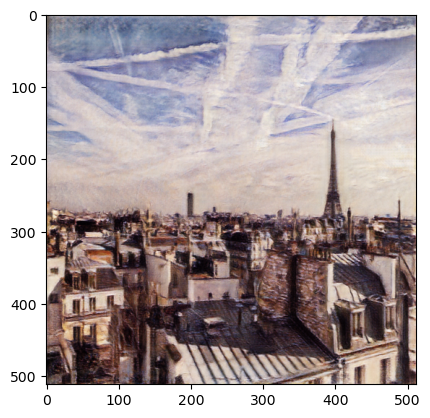

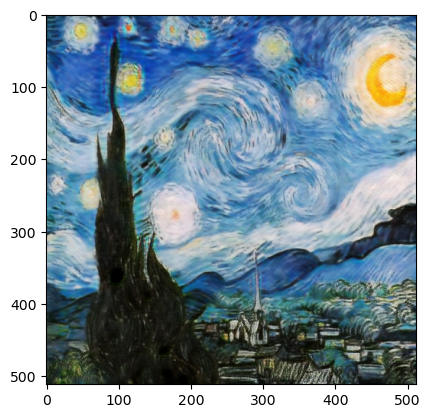

In [24]:
plt.imshow(invTrans(generated_A).squeeze(0).cpu().permute(1,2,0))
plt.show()
plt.imshow(invTrans(generated_B).squeeze(0).cpu().permute(1,2,0))
plt.show()

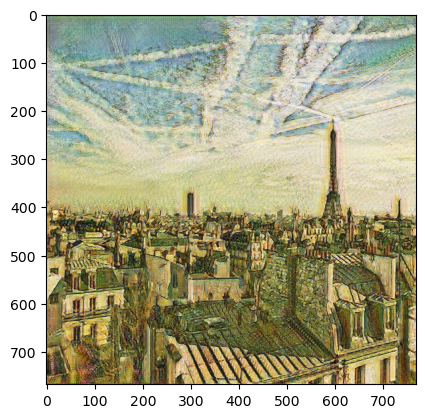

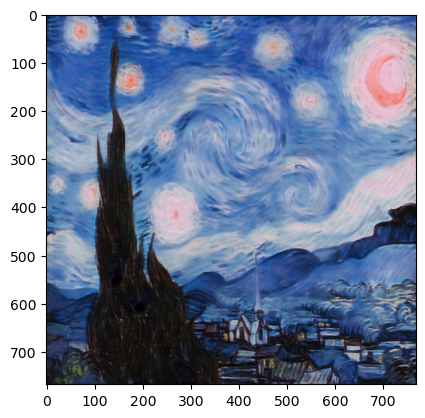

In [16]:
with torch.no_grad():
    G_AB_15.eval()
    G_BA_15.eval()
    original_A = style_img
    original_B = content_img
    generated_A = G_BA_15(original_B).detach()
    generated_B = G_AB_15(original_A).detach()
plt.imshow(invTrans(generated_A).squeeze(0).cpu().permute(1,2,0))
plt.show()
plt.imshow(invTrans(generated_B).squeeze(0).cpu().permute(1,2,0))
plt.show()

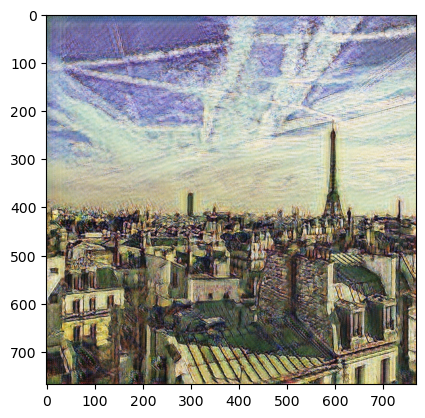

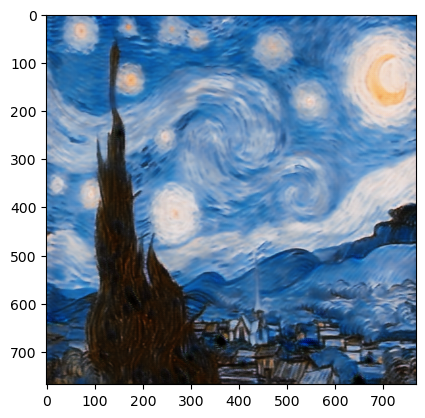

In [17]:
with torch.no_grad():
    G_AB_30.eval()
    G_BA_30.eval()
    original_A = style_img
    original_B = content_img
    generated_A = G_BA_30(original_B).detach()
    generated_B = G_AB_30(original_A).detach()
plt.imshow(invTrans(generated_A).squeeze(0).cpu().permute(1,2,0))
plt.show()
plt.imshow(invTrans(generated_B).squeeze(0).cpu().permute(1,2,0))
plt.show()